In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load datasets (change file paths)
sentiment = pd.read_csv(r"C:\Users\dell\Downloads\fear_greed_index.csv", parse_dates=["date"])  # Date, Classification
trades = pd.read_csv(r"C:\Users\dell\Downloads\historical_data.csv", parse_dates=["Timestamp IST"])  

In [10]:
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [5]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [11]:
# 2. Convert dates to a comparable format
sentiment["date_only"] = pd.to_datetime(sentiment["date"]).dt.date
trades["trade_date"] = pd.to_datetime(trades["Timestamp IST"], format="%d-%m-%Y %H:%M").dt.date

In [14]:
sentiment.dtypes

timestamp                  int64
value                      int64
classification            object
date              datetime64[ns]
date_only                 object
dtype: object

In [15]:
trades.dtypes

Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
trade_date           object
dtype: object

In [16]:
# 3. Merge datasets on date
data = trades.merge(sentiment[["date_only", "classification"]], 
                    left_on="trade_date", right_on="date_only", how="left")
data.drop(columns="date_only", inplace=True)

In [30]:
data.head(2)

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,trade_date,classification,trade_return,winner
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,Extreme Greed,0.0,False
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,Extreme Greed,0.0,False


In [17]:
# 4. Calculate per-trade return metrics
# Size USD already given, so return = Closed PnL / Size USD
data["trade_return"] = data["Closed PnL"] / data["Size USD"]
data["winner"] = data["Closed PnL"] > 0


In [18]:
# 5. Performance by sentiment
perf_sent = data.groupby("classification").agg(
    avg_return   = ("trade_return", "mean"),
    win_rate     = ("winner", "mean"),
    total_pnl    = ("Closed PnL", "sum"),
    avg_trade_usd= ("Size USD", "mean"),
    trade_count  = ("trade_return", "count")
).reset_index()

print("=== Performance by Sentiment ===")
print(perf_sent)


=== Performance by Sentiment ===
  classification  avg_return  win_rate     total_pnl  avg_trade_usd  \
0   Extreme Fear    0.004321  0.370607  7.391102e+05    5349.731843   
1  Extreme Greed    0.040027  0.464943  2.715171e+06    3112.251565   
2           Fear    0.015412  0.420768  3.357155e+06    7816.109931   
3          Greed    0.019653  0.384828  2.150129e+06    5736.884375   
4        Neutral    0.009936  0.396991  1.292921e+06    4782.732661   

   trade_count  
0        21400  
1        39980  
2        61826  
3        50283  
4        37686  


In [19]:
# 6. Performance by trader & sentiment
perf_trader_sent = data.groupby(["Account", "classification"]).agg(
    total_pnl  = ("Closed PnL", "sum"),
    avg_return = ("trade_return", "mean"),
    win_rate   = ("winner", "mean")
).reset_index()


In [20]:
# 7. Identify top traders in Fear & Greed
top_fear = perf_trader_sent[perf_trader_sent["classification"].str.contains("Fear", case=False)].nlargest(5, "total_pnl")
top_greed = perf_trader_sent[perf_trader_sent["classification"].str.contains("Greed", case=False)].nlargest(5, "total_pnl")

print("\n=== Top 5 Traders in Fear ===")
print(top_fear[["Account", "total_pnl", "win_rate"]])

print("\n=== Top 5 Traders in Greed ===")
print(top_greed[["Account", "total_pnl", "win_rate"]])


=== Top 5 Traders in Fear ===
                                        Account     total_pnl  win_rate
2    0x083384f897ee0f19899168e3b1bec365f52a9012  1.113374e+06  0.526434
143  0xbaaaf6571ab7d571043ff1e313a9609a10637864  6.208724e+05  0.498271
67   0x513b8629fe877bb581bf244e326a047b249c4ff1  3.671662e+05  0.370507
57   0x4acb90e786d897ecffb614dc822eb231b4ffb9f4  2.967817e+05  0.409026
142  0xbaaaf6571ab7d571043ff1e313a9609a10637864  2.619180e+05  0.379464

=== Top 5 Traders in Greed ===
                                        Account     total_pnl  win_rate
135  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  1.105305e+06  0.510043
137  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  5.340582e+05  0.273221
152  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  4.788115e+05  0.596311
78   0x72743ae2822edd658c0c50608fd7c5c501b2afbd  4.535953e+05  0.317032
3    0x083384f897ee0f19899168e3b1bec365f52a9012  2.767193e+05  0.160279


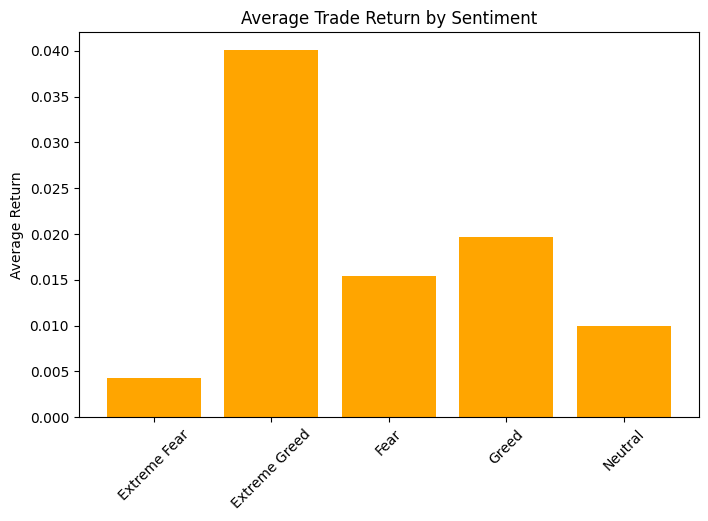

In [21]:
# 8. Visualizations
plt.figure(figsize=(8,5))
plt.bar(perf_sent["classification"], perf_sent["avg_return"], color="orange")
plt.title("Average Trade Return by Sentiment")
plt.ylabel("Average Return")
plt.xticks(rotation=45)
plt.show()


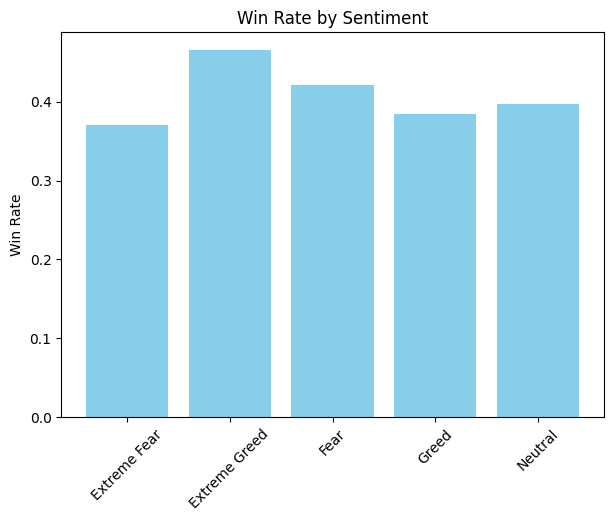

In [27]:
plt.figure(figsize=(7,5))
plt.bar(perf_sent["classification"], perf_sent["win_rate"], color="skyblue")
plt.title("Win Rate by Sentiment")
plt.ylabel("Win Rate")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 9. Quick insights
best_sent = perf_sent.loc[perf_sent["avg_return"].idxmax(), "classification"]
worst_sent = perf_sent.loc[perf_sent["avg_return"].idxmin(), "classification"]


In [29]:
print("\n=== Insights & Strategy Suggestions ===")
print(f"1. Trades perform BEST during '{best_sent}' and WORST during '{worst_sent}'.")
print("2. Focus on increasing trade frequency during best performing sentiment.")
print("3. Reduce trade size or avoid trading during worst sentiment to limit losses.")
print("4. Top Fear traders may be exploiting panic selling; study their strategies.")
print("5. Top Greed traders may ride momentum; test trend following in such periods.")


=== Insights & Strategy Suggestions ===
1. Trades perform BEST during 'Extreme Greed' and WORST during 'Extreme Fear'.
2. Focus on increasing trade frequency during best performing sentiment.
3. Reduce trade size or avoid trading during worst sentiment to limit losses.
4. Top Fear traders may be exploiting panic selling; study their strategies.
5. Top Greed traders may ride momentum; test trend following in such periods.
